# Chapter 4: Rising Seas

### Generation of plots based on [the relevant Climate Indicators' report](https://climate.copernicus.eu/climate-indicators/sea-level).

The ocean water in our planet covers over 70% of its surface, making it an ocean world. Not only that, but a large part of the global population resides near the coast, as does a lot of infrastructure and economic assets. Thus, although changes in sea level are a slow process, they can have a substantial impact in our future. 

In this tutorial we will:
1. Search, download, and view data freely available in [Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/home).
2. Use dask (within `xarray`) for chunking data due to memory limitations.
3. Calculate global timeseries and analyse trends.
4. Create timeseries plots as well as gridded plots.

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <!-- <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-c3s/main?labpath=reanalysis-climatology.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th> -->
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ECMWFCode4Earth/sketchbook-earth/blob/main/tutorials/04_sea_level/04_sea_level.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ECMWFCode4Earth/sketchbook-earth/blob/main/tutorials/04_sea_level/04_sea_level.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

### Section 1. Install & import the necessary packages.

The first step for being able to analyse and plot the data is to download and import the necessary libraries for this tutorial. In the GitHub repository you can find the full environment that has all the libraries needed for this and the other tutorials. The environment can be installed in Linux with the simple command: `conda env create -f environment.yml`. This would be the best option if you use this and the rest tutorials on your local computer. If you are using this tutorial in Google Colab most of the required libraries are already preinstalled in the environment and there are only few libraries that should be downloaded.

<div class="alert alert-block alert-warning">
    
<b>NOTE</b>: <br>
After you execute the below cell you might be prompted by Google Colab to "Restart the Runtime". If this happens, please restart the runtime and move on the next cell.
</div>

In [1]:
# download libraries not available in the default Google Colab environment
%pip install cdsapi

# need some extra arguments for intalling cartopy otherwise some features of this library break the script if it is run in Google Colab 
%pip install shapely cartopy --no-binary shapely --no-binary cartopy --force # more info at https://github.com/SciTools/cartopy/issues/1490

Let's now import all the required libraries in our environment. We categorized the libraries based on that they are used for: general libraries, libraries for data analysis, and plotting libraries.

In [2]:
# General libraries
import zipfile # for unzipping data
import os # operating system interfaces library
import cdsapi # CDS API


# Libraries for working with multidimensional arrays
import numpy as np # for n-d arrays
import xarray as xr # for n-d arrays (including metadata for all the dimensions)

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

The below is for having a consistent plotting across all tutorials. It **will NOT work in Google Colab** or other cloud services, unless you include the file (available in the Github repository) in the cloud and in the same directory as this notebook, and use the correct path, e.g.
`plt.style.use('copernicus.mplstyle')`.

In [3]:
plt.style.use('../copernicus.mplstyle') # use the predefined matplotlib style for consistent plotting across all tutorials

### Section 2. Download data from CDS.

Let's create a folder were all the data will be stored.

In [46]:
dir_loc = 'data/' # assign folder for storing the downloaded data
os.makedirs(f'{dir_loc}/monthly/', exist_ok=True) # create the folder if not available

Enter CDS API key


We will request data from the Climate Data Store (CDS) programmatically with the help of the CDS API. Let us make use of the option to manually set the CDS API credentials. First, you have to define two variables: `URL` and `KEY` which build together your CDS API key. The string of characters that make up your KEY include your personal User ID and CDS API key. To obtain these, first register or login to the CDS (http://cds.climate.copernicus.eu), then visit https://cds.climate.copernicus.eu/api-how-to and copy the string of characters listed after "key:". Replace the `#########` below with that string.

In [49]:
# CDS key
cds_url = 'https://cds.climate.copernicus.eu/api/v2'
cds_key = '########' # please add your key here the format should be as {uid}:{api-key}

Get Sea level data from [the satellite products that are available at CDS](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-level-global?tab=form).
As you can notice is the page, there is the option to download daily or monthly data. Here we use monthly data for reducing the time and storage requirements. Even with monthly data, it still needs around 15 minutes to get the data from the server, and the zipped file's size is 1Gb.

In [12]:
c = cdsapi.Client(url=cds_url, key=cds_key)

c.retrieve(
    'satellite-sea-level-global',
    {
        'version': 'vDT2021',
        'format': 'zip',
        'variable': 'monthly_mean',
        'year': list(range(1993, 2023)),
        'month': [('0'+str(i))[-2:] for i in list(range(1, 13))], # the months should be given as 2digit (e.g., '01', '12')
    },
    f'{dir_loc}/monthly/sea_level.zip')

2023-06-24 23:28:10,126 INFO Welcome to the CDS
2023-06-24 23:28:10,127 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-sea-level-global
2023-06-24 23:28:10,277 INFO Request is queued
2023-06-24 23:28:11,387 INFO Request is running
2023-06-24 23:32:31,145 INFO Request is completed
2023-06-24 23:32:31,146 INFO Downloading https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data7/dataset-satellite-sea-level-global-9474a011-e821-4b2d-85f3-1952050467ed.zip to data/sea_level.zip (995M)
2023-06-24 23:46:37,744 INFO Download rate 1.2M/s   


Result(content_length=1043362929,content_type=application/zip,location=https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data7/dataset-satellite-sea-level-global-9474a011-e821-4b2d-85f3-1952050467ed.zip)

The data are downloaded in zip format. Let's unzip them.

In [14]:
with zipfile.ZipFile(f'{dir_loc}/monthly/sea_level.zip','r') as zip_ref:
    zip_ref.extractall(f'{dir_loc}/monthly/') # unzip file

Read all the unzipped files (each file is for one year-month). This takes a little time ...

In [5]:
sea_level = xr.open_mfdataset(f'{dir_loc}/*.nc')
sea_level

<xarray.Dataset>
Dimensions:           (time: 355, nv: 2, latitude: 720, longitude: 1440)
Coordinates:
  * time              (time) datetime64[ns] 1993-01-15 1993-02-15 ... 2022-07-15
  * latitude          (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude         (longitude) float32 0.125 0.375 0.625 ... 359.6 359.9
  * nv                (nv) int32 0 1
Data variables:
    crs               (time) int32 -2147483647 -2147483647 ... -2147483647
    climatology_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds          (time, latitude, nv) float32 dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bnds          (time, longitude, nv) float32 dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    sla               (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    eke               (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/43)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Monthly Mean of Sea Level Anomalies refe...
    contact:                         http://climate.copernicus.eu/c3s-user-se...
    creator_email:                   http://climate.copernicus.eu/c3s-user-se...
    ...                              ...
    summary:                         Delayed Time Level-4 monthly means of Se...
    time_coverage_duration:          P1M
    time_coverage_end:               1993-01-31T00:00:00Z
    time_coverage_resolution:        P1M
    time_coverage_start:             1993-01-01T00:00:00Z
    title:                           DT merged two-satellite Global Ocean L4 ...

In [6]:
# change longitudes to -180 | 180
sla = sea_level['sla']
sla_180 = sla.assign_coords(longitude=(((sla.longitude + 180) % 360) - 180)).sortby('longitude')
sla_180 

<xarray.DataArray 'sla' (time: 355, latitude: 720, longitude: 1440)>
dask.array<getitem, shape=(355, 720, 1440), dtype=float64, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1993-01-15 1993-02-15 ... 2022-07-15
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Attributes:
    cell_methods:   time: mean within years
    grid_mapping:   crs
    long_name:      Averaged Sea Level Anomalies 1993/01
    standard_name:  sea_surface_height_above_sea_level
    units:          m

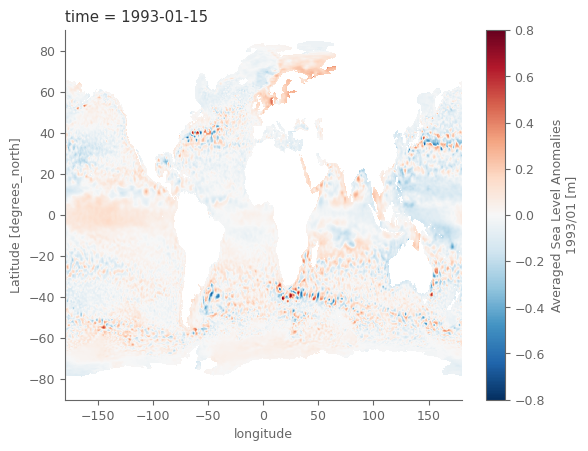

In [7]:
# "quick and dirty" plot of the data
sla_180.isel(time=0).plot() 

### Section 3. Global average

The data are projected in lat/lon system. This system does not have equal areas for all grid cells, but as we move closer to the poles, the areas of the cells are reducing. These differences can be accounted when weighting the cells with the cosine of their latitude.

In [8]:
def area_weighted_spatial_average(data):
    """Calculate area-weighted spatial average of data
    
    Parameters
    ----------
    data : xarray.DataArray
        DataArray with lat and lon coordinates

    Returns
    -------
    xarray.DataArray
        Area-weighted spatial average
    
    """
    weights = np.cos(np.deg2rad(data.latitude)).clip(0, 1) # weights
    return data.weighted(weights).mean(['latitude', 'longitude'])

Calculate global average sea level anomaly. This will take a while...

In [9]:
global_average_sla = area_weighted_spatial_average(sla_180).compute()

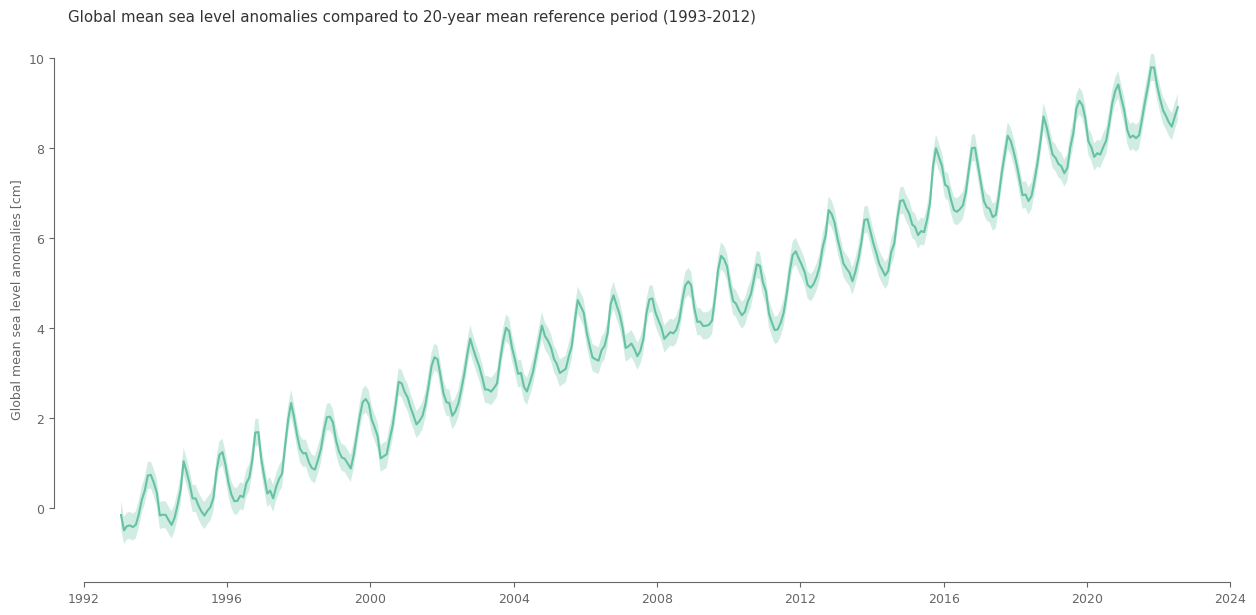

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
(100*global_average_sla).plot(ax=ax) # plot in cm rather than m that is the unit of the data
plt.fill_between(global_average_sla.time.values, 100*global_average_sla-.3, 100*global_average_sla+.3, alpha=.3)

sns.despine(ax=ax, trim=True, offset=10) # trimming the y and x axis to be visible only from the fist till the last tick
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # formatting is needed cause the above line breaks the time fo

ax.set_xlabel('')
ax.set_ylabel('Global mean sea level anomalies [cm]')
ax.set_title('Global mean sea level anomalies compared to 20-year mean reference period (1993-2012)')

plt.show()

### Section 4. Trend analysis

In [12]:
sla_europe = sla_180.sel(latitude=slice(24, 90), longitude=slice(-18, 40)).compute()

In [23]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs

In [29]:
sla_180 = sla_180.chunk(chunks={'time': -1, 'latitude': 72, 'longitude': 144}) # rechunk so time is not segmented (needed for trends)

In [30]:
trends = (sla_180.groupby('time.year').mean().polyfit(dim='year', deg=1)['polyfit_coefficients'].sel(degree=1)*1000) # trends in mm/year

In [32]:
trends = trends.compute()

/home/nikos_mastrantonas/anaconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/nputils.py:191: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/nikos_mastrantonas/anaconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/nputils.py:191: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/nikos_mastrantonas/anaconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/nputils.py:191: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/nikos_mastrantonas/anaconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/nputils.py:191: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/nikos_mastrantonas/anaconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/nputils.py:191: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/nikos_mastrant

In [45]:
trends.sel(latitude=slice(24, 65), longitude=slice(-18, 40)).min()

<xarray.DataArray 'polyfit_coefficients' ()>
array(-12.875)
Coordinates:
    degree   int64 1

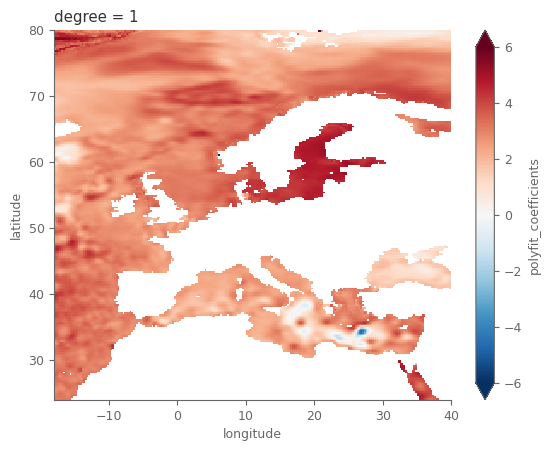

In [38]:
trends.sel(latitude=slice(24, 80), longitude=slice(-18, 40)).plot(vmin=-6, vmax=6, cmap='RdBu_r', extend='both')

/home/nikos_mastrantonas/anaconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/nputils.py:191: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


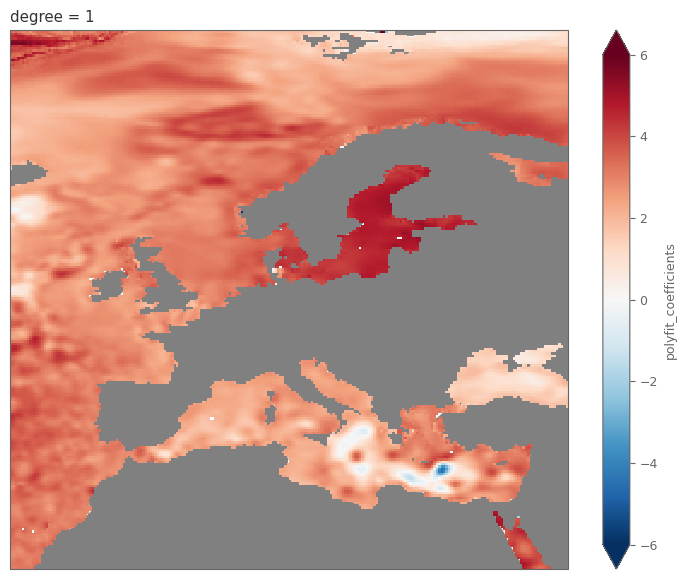

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), subplot_kw={'projection': ccrs.PlateCarree()})
trends_europe = (sla_europe.groupby('time.year').mean().polyfit(dim='year', deg=1)['polyfit_coefficients'].sel(degree=1)*1000)
trends_europe.sel(latitude=slice(24, 80)).plot(vmin=-6, vmax=6, cmap='RdBu_r', extend='both', ax=ax)
ax.add_feature(cfeature.LAND, color='grey', lw=.5)

In [128]:
global_average_sla.groupby('time.year').mean().polyfit(dim='year', deg=1)['polyfit_coefficients'].sel(degree=1)*1000

<xarray.DataArray 'polyfit_coefficients' ()>
array(3.10070757)
Coordinates:
    degree   int64 1

In [1]:
global_average_sla.time

NameError: name 'global_average_sla' is not defined

In [124]:
(global_average_sla).polyfit(dim='time', deg=1)['polyfit_coefficients']*1000*12

<xarray.DataArray 'polyfit_coefficients' (degree: 2)>
array([ 1.18518202e-15, -9.05509629e+02])
Coordinates:
  * degree   (degree) int64 1 0

/home/nikos_mastrantonas/anaconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/nputils.py:191: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


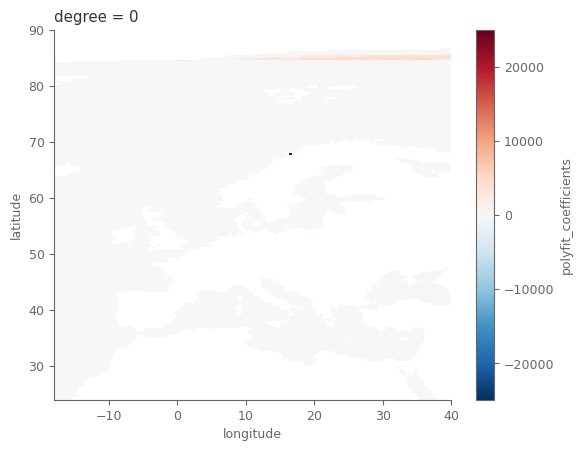

In [114]:
(sla_europe.polyfit(dim='time', deg=1).sel(degree=0)*1000)['polyfit_coefficients'].plot()

In [34]:
from sklearn.linear_model import LinearRegression

### Appendix: Calculations for daily data

This requires 30Gb of data and a considerable amount of time for the calculations...

In [47]:
os.makedirs(f'{dir_loc}/daily/', exist_ok=True) # create the folder if not available

In [50]:
c = cdsapi.Client(url=cds_url, key=cds_key)

for i_year in range(1993, 2023):
    c.retrieve(
        'satellite-sea-level-global',
        {
            'version': 'vDT2021',
            'format': 'zip',
            'variable': 'daily',
            'year': i_year,
            'month': [('0'+str(i))[-2:] for i in list(range(1, 13))], # the months should be given as 2digit (e.g., '01', '12'),
            'day': [('0'+str(i))[-2:] for i in list(range(1, 32))], # the months should be given as 2digit (e.g., '01', '31'),
        },
        f'{dir_loc}/daily/{i_year}_sea_level.zip')

2023-06-25 04:43:19,538 INFO Welcome to the CDS
2023-06-25 04:43:19,539 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-sea-level-global
2023-06-25 04:43:19,691 INFO Request is queued
2023-06-25 04:43:20,854 INFO Request is running
2023-06-25 04:53:42,859 INFO Request is completed
2023-06-25 04:53:42,860 INFO Downloading https://download-0004-clone.copernicus-climate.eu/cache-compute-0004/cache/data6/dataset-satellite-sea-level-global-0b974868-2162-4a3d-b7df-89cb063bc9bf.zip to data//daily/1993_sea_level.zip (3.3G)
2023-06-25 05:40:31,960 INFO Download rate 1.2M/s    
2023-06-25 05:40:32,722 INFO Welcome to the CDS
2023-06-25 05:40:32,723 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-sea-level-global
2023-06-25 05:40:32,864 INFO Request is queued
2023-06-25 05:40:34,050 INFO Request is running


KeyboardInterrupt: 

In [51]:
with zipfile.ZipFile(f'{dir_loc}/daily/1993_sea_level.zip','r') as zip_ref:
    zip_ref.extractall(f'{dir_loc}/daily/') # unzip file